Objective:
To reduce costs by 15% through better inventory management and logistics planning.

Develop mathematical models to represent the supply chain, focusing on different aspects such as inventory levels, transportation, and production schedules.

Mathematical Model:

Objective Function:
Minimize Total Cost = Production Costs + Transportation Costs + Inventory Holding Costs

Constraints:


Demand Satisfaction: Ensure demand for all products at all locations is met.

Capacity Constraints: Production and transportation must not exceed their respective capacities.

Inventory Balance: Inventory at each period must account for previous inventory, production, and demand.

Lead Time Constraints: Incorporate lead times for production and transportation.

Non-negativity Constraints: Variables representing quantities must be non-negative.

Mathematical Formulation:


Minimize

∑ 
i,j
​
 P 
ij
​
 x 
ij
​
 +∑ 
i,k
​
 T 
ik
​
 y 
ik
​
 +∑ 
i
​
 H 
i
​
 I 
i
​

Subject to:

∑ 
i
​
 x 
ij
​
 =D 
j
​
 
 ∀j
 
∑ 
j
​
 x 
ij
​
 ≤C 
i
​
 
 ∀i
 
I 
t+1
​
 =I 
t
​
 +∑ 
i
​
 x 
ij
​
 −D 
j
​
   ∀t
 
x 
ij
​
 ,y 
ik
​
 ,I 
i
​
 ≥0
 

Optimization Algorithms

Appropriate algorithms based on the nature of the problem:


Linear Programming (LP): For problems with linear objective functions and constraints.

Mixed-Integer Linear Programming (MILP): For problems that involve integer variables.

Metaheuristics: For large and complex problems where exact solutions are infeasible.

In [1]:
import pulp
import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load the dataset from the provided CSV file
file_path = 'data/supply_chain_data.csv'
data = pd.read_csv(file_path)

# Validate data
assert not data.isnull().values.any(), "Data contains missing values!"

# Display the first few rows of the dataset
data.head()

,Product type,SKU,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,...,Location,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs
0,haircare,SKU0,69.808006,55,802,8661.996792,Non-binary,58,7,96,...,Mumbai,29,215,29,46.279879,Pending,0.226410,Road,Route B,187.752075
1,skincare,SKU1,14.843523,95,736,7460.900065,Female,53,30,37,...,Mumbai,23,517,30,33.616769,Pending,4.854068,Road,Route B,503.065579
2,haircare,SKU2,11.319683,34,8,9577.749626,Unknown,1,10,88,...,Mumbai,12,971,27,30.688019,Pending,4.580593,Air,Route C,141.920282
3,skincare,SKU3,61.163343,68,83,7766.836426,Non-binary,23,13,59,...,Kolkata,24,937,18,35.624741,Fail,4.746649,Rail,Route A,254.776159
4,skincare,SKU4,4.805496,26,871,2686.505152,Non-binary,5,3,56,...,Delhi,5,414,3,92.065161,Fail,3.145580,Air,Route A,923.440632


In [3]:
# Print the column names to verify
print("Column names in the dataset:", data.columns.tolist())

Column names in the dataset: ['Product type', 'SKU', 'Price', 'Availability', 'Number of products sold', 'Revenue generated', 'Customer demographics', 'Stock levels', 'Lead times', 'Order quantities', 'Shipping times', 'Shipping carriers', 'Shipping costs', 'Supplier name', 'Location', 'Lead time', 'Production volumes', 'Manufacturing lead time', 'Manufacturing costs', 'Inspection results', 'Defect rates', 'Transportation modes', 'Routes', 'Costs']


Unique suppliers, products, and time periods are extracted from the data.

Dictionaries are created for:

Production Costs: Indexed by location and SKU.

Transportation Costs: Indexed by routes and SKU.

Capacities: Indexed by location.

Checks for an 'Initial Inventory' column and sets it up if present; otherwise, initializes inventory to zero.

Generates random demand data for each product over the time periods.

Problem Definition: The problem is defined as a minimization problem.

Decision Variables:

Production (x): Amount produced by each supplier for each product and time period.

Transportation (y): Amount transported from each supplier for each product and time period.

Inventory (I): Inventory levels for each product and time period.

Shortage (S): Shortages for each product and time period.

The objective is to minimize the total cost, which includes production, transportation, holding, and shortage costs.

Defining Constraints:

Inventory Balance: Ensures the balance between production, transportation, inventory, and demand.

Capacity: Ensures production does not exceed supplier capacities.

Transport Capacity: Ensures transportation does not exceed the defined transport capacity.

In [4]:
# Extract unique suppliers, products, and time periods
suppliers = data['Location'].unique().tolist()
products = data['SKU'].unique().tolist()
time_periods = range(1, 13)  # Assuming 12 time periods for a year

# Create dictionaries for production and transportation costs, capacities, and demand
production_costs = data.set_index(['Location', 'SKU'])['Manufacturing costs'].to_dict()
transportation_costs = data.set_index(['Routes', 'SKU'])['Costs'].to_dict()
capacities = data.set_index('Location')['Availability'].to_dict()

# Check if 'Initial Inventory' column exists, otherwise set to zero
if 'Initial Inventory' in data.columns:
    initial_inventory = data.set_index('SKU')['Initial Inventory'].to_dict()
else:
    initial_inventory = {p: 0 for p in products}

# Generate random demand data for each product and time period
demand = {p: [random.randint(50, 150) for _ in time_periods] for p in products}

# Define holding and shortage costs
holding_costs = (data.set_index('SKU')['Price'] * 0.01).to_dict()
shortage_costs = (data.set_index('SKU')['Price'] * 0.05).to_dict()

# Define a transport capacity for simplicity, here as a constant value
transport_capacity = 1000  # Example constant value

# Define the optimization problem
prob = pulp.LpProblem("MultiPeriodSupplyChainOptimization", pulp.LpMinimize)

# Define decision variables
x = pulp.LpVariable.dicts("production", (suppliers, products, time_periods), lowBound=0, cat='Continuous')
y = pulp.LpVariable.dicts("transportation", (suppliers, products, time_periods), lowBound=0, cat='Continuous')
I = pulp.LpVariable.dicts("inventory", (products, time_periods), lowBound=0, cat='Continuous')
S = pulp.LpVariable.dicts("shortage", (products, time_periods), lowBound=0, cat='Continuous')

# Define the objective function
prob += pulp.lpSum([production_costs.get((i, j), 0) * x[i][j][t] for i in suppliers for j in products for t in time_periods]) + \
        pulp.lpSum([transportation_costs.get((r, j), 0) * y[r][j][t] for r in suppliers for j in products for t in time_periods]) + \
        pulp.lpSum([holding_costs.get(j, 0) * I[j][t] for j in products for t in time_periods]) + \
        pulp.lpSum([shortage_costs.get(j, 0) * S[j][t] for j in products for t in time_periods])

# Define the constraints
for j in products:
    for t in time_periods:
        if t == 1:
            prob += I[j][t] + S[j][t] + pulp.lpSum([x[i][j][t] for i in suppliers if (i, j) in production_costs]) - pulp.lpSum([y[r][j][t] for r in suppliers if (r, j) in transportation_costs]) == initial_inventory.get(j, 0) - demand[j][t-1], f"Inventory_Balance_{j}_{t}"
        else:
            prob += I[j][t] + S[j][t] + pulp.lpSum([x[i][j][t] for i in suppliers if (i, j) in production_costs]) - pulp.lpSum([y[r][j][t] for r in suppliers if (r, j) in transportation_costs]) == I[j][t-1] + S[j][t-1] - demand[j][t-1], f"Inventory_Balance_{j}_{t}"

for i in suppliers:
    for t in time_periods:
        prob += pulp.lpSum([x[i][j][t] for j in products if (i, j) in production_costs]) <= capacities[i], f"Capacity_{i}_{t}"

# Additional Constraints: Transport Capacity
for j in products:
    for t in time_periods:
        prob += pulp.lpSum([y[r][j][t] for r in suppliers if (r, j) in transportation_costs]) <= transport_capacity, f"TransportCapacity_{j}_{t}"

# Solve the problem
prob.solve()

# Output results
results = []
for v in prob.variables():
    results.append((v.name, v.varValue))
    print(f"{v.name} = {v.varValue}")

total_cost = pulp.value(prob.objective)
print(f"Total Cost = {total_cost}")

# Store results in a DataFrame
results_df = pd.DataFrame(results, columns=['Variable', 'Value'])
results_df.to_csv('generated_csv/optimization_results.csv', index=False)

inventory_SKU0_1 = 0.0
inventory_SKU0_10 = 0.0
inventory_SKU0_11 = 0.0
inventory_SKU0_12 = 0.0
inventory_SKU0_2 = 0.0
inventory_SKU0_3 = 0.0
inventory_SKU0_4 = 0.0
inventory_SKU0_5 = 0.0
inventory_SKU0_6 = 0.0
inventory_SKU0_7 = 0.0
inventory_SKU0_8 = 0.0
inventory_SKU0_9 = 0.0
inventory_SKU10_1 = 0.0
inventory_SKU10_10 = 0.0
inventory_SKU10_11 = 0.0
inventory_SKU10_12 = 0.0
inventory_SKU10_2 = 0.0
inventory_SKU10_3 = 0.0
inventory_SKU10_4 = 0.0
inventory_SKU10_5 = 0.0
inventory_SKU10_6 = 0.0
inventory_SKU10_7 = 0.0
inventory_SKU10_8 = 0.0
inventory_SKU10_9 = 0.0
inventory_SKU11_1 = 0.0
inventory_SKU11_10 = 0.0
inventory_SKU11_11 = 0.0
inventory_SKU11_12 = 0.0
inventory_SKU11_2 = 0.0
inventory_SKU11_3 = 0.0
inventory_SKU11_4 = 0.0
inventory_SKU11_5 = 0.0
inventory_SKU11_6 = 0.0
inventory_SKU11_7 = 0.0
inventory_SKU11_8 = 0.0
inventory_SKU11_9 = 0.0
inventory_SKU12_1 = 0.0
inventory_SKU12_10 = 0.0
inventory_SKU12_11 = 0.0
inventory_SKU12_12 = 0.0
inventory_SKU12_2 = 0.0
inventory_SKU12_

Demand Generator: Simulates demand occurring over time.

Environment Setup: Creates a simulation environment and runs the demand generator.

Output: Prints and saves the simulated demand data to a CSV file.

In [5]:
# Simulation
def demand_generator(env, demand_rate, demand):
    while True:
        yield env.timeout(random.expovariate(demand_rate))
        demand.append(env.now)

# Set up environment
env = simpy.Environment()

# Define demand list
demand = []

# Start demand generator process
env.process(demand_generator(env, demand_rate=1, demand=demand))

# Run simulation
env.run(until=100)

# Output demand over time
print(demand)

# Store demand data
demand_df = pd.DataFrame(demand, columns=['Time'])
demand_df.to_csv('generated_csv/demand_simulation.csv', index=False)

[0.3732477457734696, 0.63142489745027, 1.1188887842730086, 1.7148841283771383, 1.9260585851357948, 3.2146574671432866, 5.241222858290937, 7.4352640049366325, 8.081267500641214, 9.210499609767801, 10.181889559705288, 10.322727401620774, 11.135163359529447, 12.884463491550887, 14.694495558712942, 16.108428845244983, 17.018678568593465, 19.990689247085744, 20.766977856797617, 22.978627334962766, 24.823431057709378, 24.925524403346266, 24.94560490541298, 25.016790768451866, 28.532250129670455, 28.645380818656854, 29.004750578998937, 29.19605417143706, 30.013933456096545, 31.879660172175225, 31.943918032293364, 32.23709669517917, 32.38808441771363, 32.49063024383601, 34.75953181918001, 36.05060545542734, 36.0562523296583, 37.750795732727305, 39.39097079406678, 39.91300288988459, 40.169776205445885, 41.01107733087536, 41.40179834240183, 41.95846292168707, 42.37084609073718, 43.16998019389302, 44.38302602614394, 44.886199714912884, 45.67094771165175, 46.295216127836234, 46.44740484529855, 46.

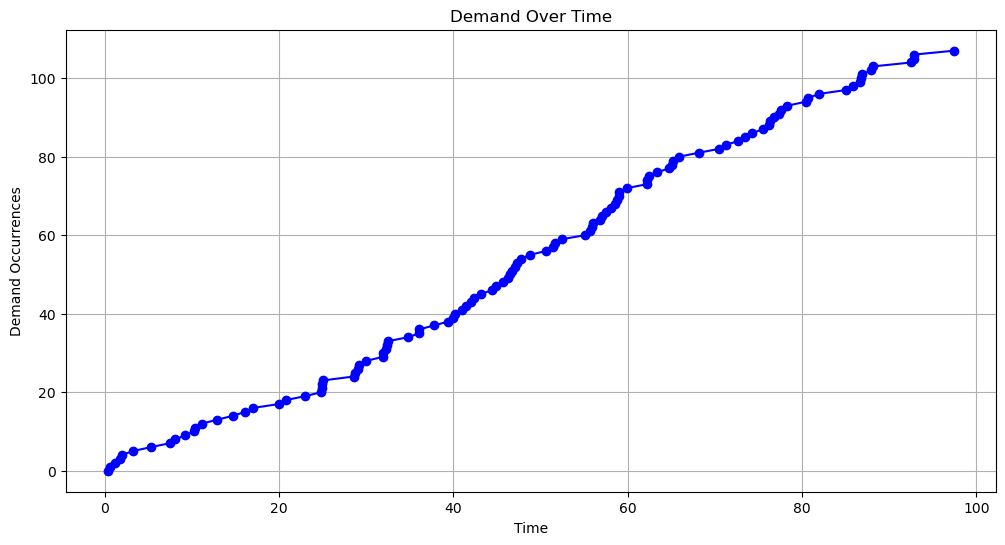

In [6]:
# Visualization
plt.figure(figsize=(12, 6))
plt.plot(demand_df['Time'], range(len(demand_df)), marker='o', linestyle='-', color='b')
plt.xlabel('Time')
plt.ylabel('Demand Occurrences')
plt.title('Demand Over Time')
plt.grid(True)
plt.show()

The code performs the following tasks:

Data Preparation: Reads and validates data from a CSV file.

Optimization Setup: Defines a supply chain optimization problem using linear programming to minimize costs associated with production, transportation, holding, and shortages.

Simulation: Uses a discrete-event simulation to model demand over time.

Results: Solves the optimization problem, prints, saves results, and visualizes demand data.

This comprehensive approach combines optimization and simulation to address supply chain management challenges.